<a href="https://colab.research.google.com/github/vipin-jangra/face-age-estimation-CNN/blob/main/D2_CNN2_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import re
import cv2
import keras
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.applications import ResNet101
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.applications.resnet50 import preprocess_input

In [3]:
def preprocess_image(image_path):
    # Read grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize image to (224, 224)
    image = cv2.resize(image, (224, 224))
    # Convert grayscale to RGB by stacking the single channel
    image_rgb = np.stack((image,) * 3, axis=-1)
    # Preprocess image for ResNet50 model
    image_rgb = preprocess_input(image_rgb)
    return image_rgb

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define age group conversion
def age_to_range(age):
    return age // 3 # Convert ages to 3-year interval indices

In [6]:
def preprocess_labels(labels, num_classes):
    # One-hot encode labels
    labels = to_categorical(labels, num_classes=num_classes)
    return labels

In [7]:
# Load and preprocess the dataset
image_dir = '/content/drive/MyDrive/Dataset/Dataset2/FGNET/images'
images=[]
image_paths = []
age_labels = []
age_groups = []
target_size = (224, 224)

for filename in os.listdir(image_dir):
  if filename.endswith(".JPG"):
    match = re.search(r'A(\d+)', filename)
    age_str = match.group(1)
    age = int(age_str)
    range_index = age_to_range(age)
    age_labels.append(range_index)

    image_path = os.path.join(image_dir, filename)
    image = preprocess_image(image_path)
    images.append(image)
    image_paths.append(image_path)

images = np.array(images)
age_groups = age_labels
age_labels = preprocess_labels(age_labels, np.max(age_groups)+1)

In [8]:
# Print shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {age_labels.shape}")

Images shape: (1002, 224, 224, 3)
Labels shape: (1002, 24)


In [9]:
def age_group_to_interval(group_index, interval=5):
    start = group_index * interval
    end = (group_index + 1) * interval - 1
    return f"{start}-{end}"

In [10]:
import pandas as pd
df = pd.DataFrame()
age_intervals = [age_group_to_interval(age) for age in age_groups]
df['images_path'],df['age'] = image_paths,age_intervals
df.head(10)

,images_path,age
0,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,10-14
1,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,0-4
2,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,15-19
3,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,5-9
4,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,70-74
5,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,30-34
6,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,50-54
7,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,85-89
8,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,95-99
9,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,50-54


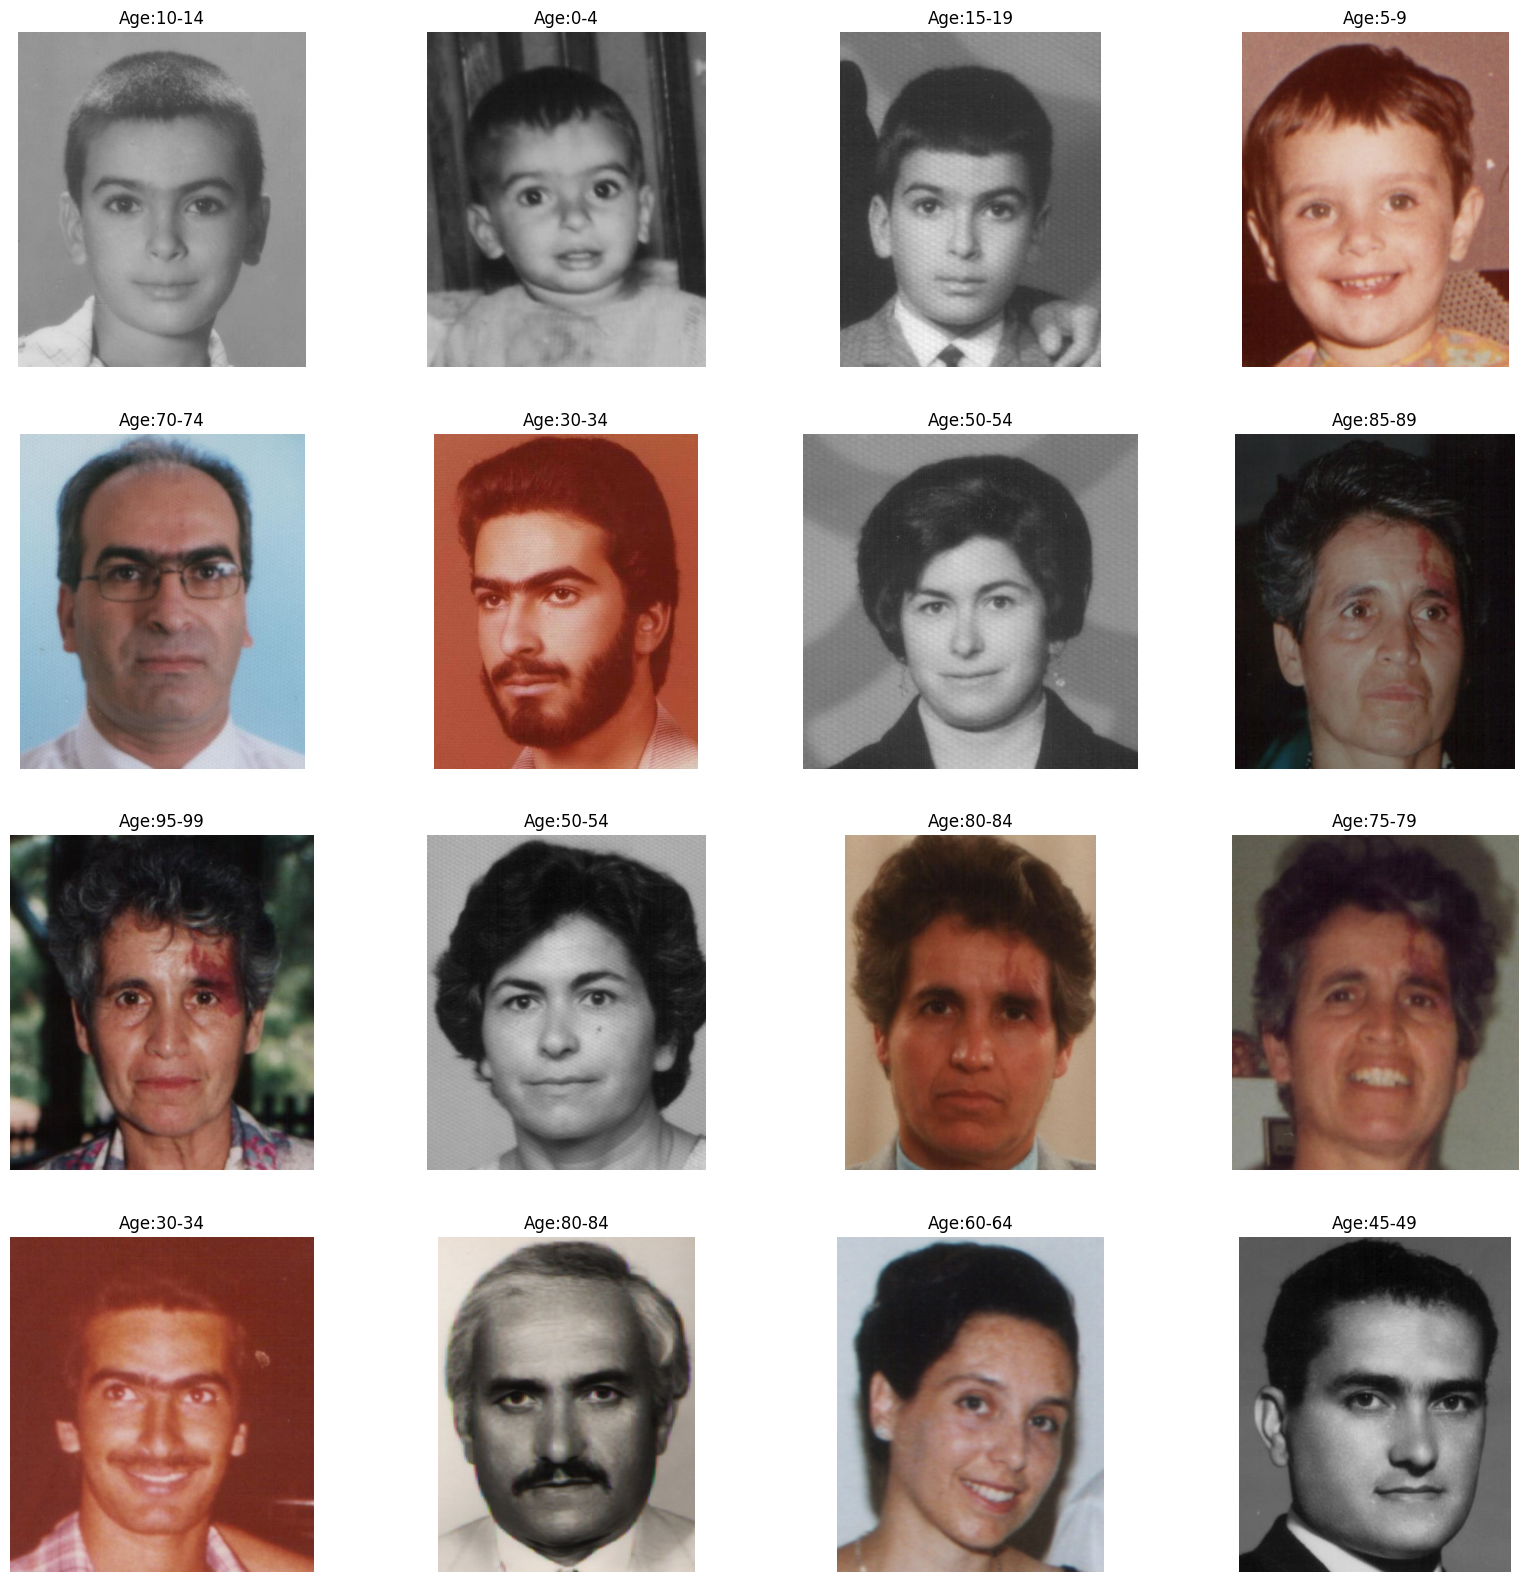

In [11]:
plt.figure(figsize=(20,20))
samples = df.iloc[0:16]

for index,sample,age in samples.itertuples():
  plt.subplot(4,4,index+1)
  img = load_img(sample)
  img = np.array(img)
  plt.axis('off')
  plt.title(f'Age:{age}')
  plt.imshow(img)

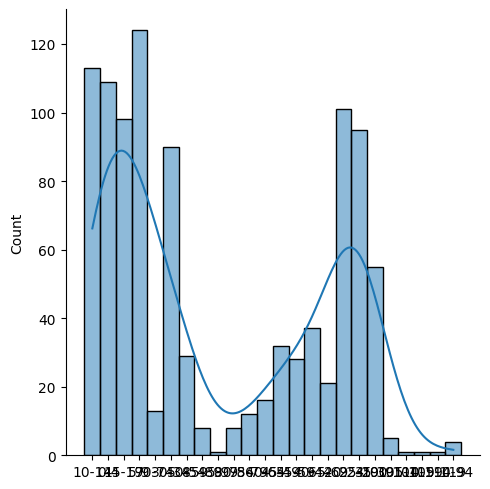

In [12]:
#age distribution
sns.displot(data=age_intervals,kde=True)

In [13]:
train_images, test_images, train_age_groups, test_age_groups = train_test_split(images, age_labels, test_size=0.2, random_state=42)


In [14]:
# Load the pre-trained ResNet50 model
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(132, activation='relu')(x)
predictions = Dense(np.max(age_groups) + 1, activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


171446536/171446536 [==============================] - 8s 0us/step


In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
   '/content/drive/MyDrive/Dataset/Dataset2/model-weights/D2_CNN2_A1.h5',  # Filepath to save the best model
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,
    save_best_only=True,  # Only save the best model
    mode='max'  # Mode to determine best (maximizing validation accuracy)
)


In [16]:
model.fit(train_images, train_age_groups, validation_split=0.2, epochs=60, batch_size=32, callbacks=[early_stopping,model_checkpoint], shuffle=False)


Epoch 1/60
20/20 [==============================] - ETA: 0s - loss: 2.9279 - accuracy: 0.1266
Epoch 1: val_accuracy improved from -inf to 0.02484, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D2_CNN2_A1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 79s 605ms/step - loss: 2.9279 - accuracy: 0.1266 - val_loss: 59308140.0000 - val_accuracy: 0.0248
Epoch 2/60
20/20 [==============================] - ETA: 0s - loss: 2.4942 - accuracy: 0.1906
Epoch 2: val_accuracy improved from 0.02484 to 0.08075, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D2_CNN2_A1.h5
20/20 [==============================] - 8s 402ms/step - loss: 2.4942 - accuracy: 0.1906 - val_loss: 2111509.2500 - val_accuracy: 0.0807
Epoch 3/60
20/20 [==============================] - ETA: 0s - loss: 2.2834 - accuracy: 0.2297
Epoch 3: val_accuracy improved from 0.08075 to 0.11801, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D2_CNN2_A1.h5
20/20 [==============================] - 8s 425ms/step - loss: 2.2834 - accuracy: 0.2297 - val_loss: 4046.5972 - val_accuracy: 0.1180
Epoch 4/60
20/20 [==============================] - ETA: 0s - loss: 2.1575 - accuracy: 0.2797
Epoch 4: val_accuracy did no

In [17]:
# Load the best model
model.load_weights('/content/drive/MyDrive/Dataset/Dataset2/model-weights/D2_CNN2_A1.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_age_groups)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


7/7 [==============================] - 1s 172ms/step - loss: 5.0034 - accuracy: 0.2239
Test Accuracy: 22.39%


In [18]:

predictions = model.predict(test_images)

# Convert predictions to class labels if needed
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_age_groups, axis=1)

7/7 [==============================] - 2s 75ms/step


In [19]:
# Example metrics calculation
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.69      0.92      0.79        12
           1       0.48      0.42      0.45        26
           2       0.32      0.46      0.38        24
           3       0.11      0.11      0.11        19
           4       0.17      0.33      0.22        15
           5       0.22      0.14      0.17        28
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.20      0.12      0.15         8
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         2
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [20]:
# Calculate classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.22
Precision: 0.20
Recall: 0.22
F1-score: 0.21


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Calculate accuracy for each class
class_accuracies = {}
for idx in range(np.max(age_groups) + 1):
    # Filter predictions and true labels for the current class
    mask = (true_classes == idx)
    accuracy = accuracy_score(true_classes[mask], predicted_classes[mask])
    class_accuracies[age_group_to_interval(idx)] = accuracy

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [22]:
# Print accuracy for each class
for age_range, accuracy in class_accuracies.items():
    print(f'Accuracy for age range {age_range}: {accuracy:.2f}')

Accuracy for age range 0-4: 0.92
Accuracy for age range 5-9: 0.42
Accuracy for age range 10-14: 0.46
Accuracy for age range 15-19: 0.11
Accuracy for age range 20-24: 0.33
Accuracy for age range 25-29: 0.14
Accuracy for age range 30-34: 0.00
Accuracy for age range 35-39: 0.00
Accuracy for age range 40-44: 0.00
Accuracy for age range 45-49: 0.00
Accuracy for age range 50-54: 0.00
Accuracy for age range 55-59: 0.00
Accuracy for age range 60-64: 0.00
Accuracy for age range 65-69: 0.12
Accuracy for age range 70-74: 0.00
Accuracy for age range 75-79: 0.00
Accuracy for age range 80-84: 0.00
Accuracy for age range 85-89: 0.00
Accuracy for age range 90-94: 0.00
Accuracy for age range 95-99: nan
Accuracy for age range 100-104: nan
Accuracy for age range 105-109: nan
Accuracy for age range 110-114: 0.00
Accuracy for age range 115-119: 0.00
